In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt
import pvlib

import cpvlib
from module_parameters import mod_params_cpv, mod_params_flatplate

In [4]:
lat, lon = 40.4, -3.7

data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

data = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data.set_index(
    data.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=695, tz='utc')

solar_zenith = location.get_solarposition(data.index).zenith
solar_azimuth = location.get_solarposition(data.index).azimuth

StaticHybridSystem

In [5]:
static_hybrid_sys = cpvlib.StaticHybridSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module_cpv=None,
    module_flatplate=None,
    module_parameters_cpv=mod_params_cpv,
    module_parameters_flatplate=mod_params_flatplate,
    modules_per_string=1,
    strings_per_inverter=1,
    inverter=None,
    inverter_parameters=None,
    racking_model="insulated",
    losses_parameters=None,
    name=None,
)

get_effective_irradiance

In [6]:
data['dii_effective'], data['poa_flatplate_static_effective'] = static_hybrid_sys.get_effective_irradiance(
    solar_zenith,
    solar_azimuth,
    #iam_param=0.7,
    #aoi_limit=55,
    dii=None,
    ghi=data['ghi'],
    dhi=data['dhi'],
    dni=data['dni']
)

pvsyst_celltemp

In [7]:
data['temp_cell_35'], data['temp_cell_flatplate'] = static_hybrid_sys.pvsyst_celltemp(
    dii=data['dii_effective'],
    poa_flatplate_static=data['poa_flatplate_static_effective'],
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

calcparams_pvsyst

In [8]:
diode_parameters_cpv, diode_parameters_flatplate = static_hybrid_sys.calcparams_pvsyst(
    dii=data['dii_effective'],
    poa_flatplate_static=data['poa_flatplate_static_effective'],
    temp_cell_cpv=data['temp_cell_35'],
    temp_cell_flatplate=data['temp_cell_flatplate'],
)

singlediode

In [9]:
dc_cpv, dc_flatplate = static_hybrid_sys.singlediode(
    diode_parameters_cpv, diode_parameters_flatplate)

uf_global (uf_am, uf_temp_air)

In [10]:
airmass_absolute = location.get_airmass(data.index).airmass_absolute

uf_cpv = static_hybrid_sys.get_global_utilization_factor_cpv(airmass_absolute, data['temp_air'])

Power

<IPython.core.display.Javascript object>


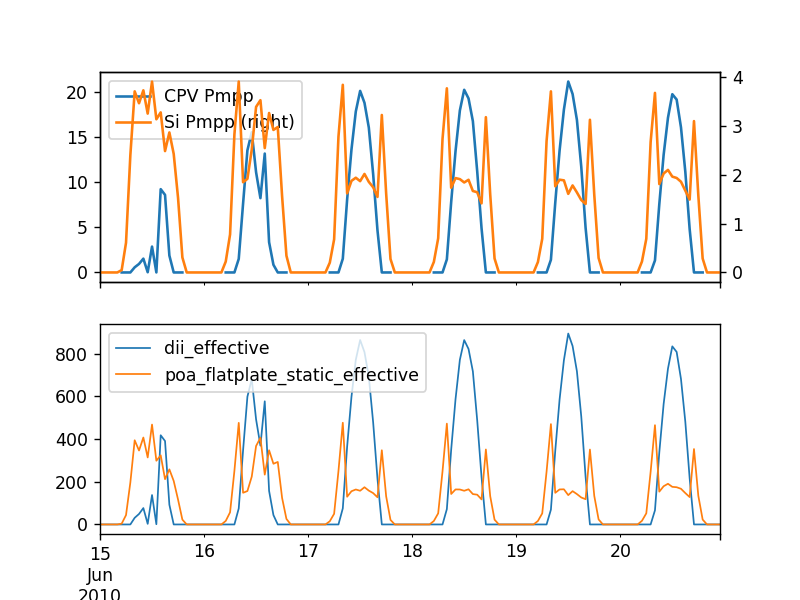

<AxesSubplot:xlabel='time(UTC)'>

In [25]:
cpv_days = dc_cpv['2010-06-15':'2010-06-20']
uf_cpv_days = uf_cpv['2010-06-15':'2010-06-20']
flatplate_days = dc_flatplate['2010-06-15':'2010-06-20']
data_days = data['2010-06-15':'2010-06-20']

fig, axs = plt.subplots(2)

(cpv_days.p_mp * uf_cpv_days).plot(ax=axs[0], legend=True, label="CPV Pmpp")
flatplate_days.p_mp.plot(ax=axs[0], secondary_y=True, legend=True, label="Si Pmpp")
data_days[['dii_effective', 'poa_flatplate_static_effective']].plot(ax=axs[1], linewidth=1)

Energy

In [12]:
energy_cpv = (dc_cpv['p_mp'] * uf_cpv).sum()
energy_flatplate = dc_flatplate['p_mp'].sum()

print(f"E_CPV={energy_cpv:.0f} Wh", f"E_diff={energy_flatplate:.0f} Wh")

E_CPV=25758 Wh E_diff=8833 Wh
